# deep learning for asset pricing

In [1]:
!pip install yfinance fredapi torch pandas numpy matplotlib scikit-learn ta -q

  Preparing metadata (setup.py) ... done


In [2]:
!pip install tqdm -q

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
!pip install -q --upgrade --no-cache-dir git+https://github.com/rongardF/tvdatafeed.git

  Preparing metadata (setup.py) ... done


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import yfinance as yf
from tvDatafeed import TvDatafeed, Interval
from fredapi import Fred
import matplotlib.pyplot as plt
from ta import add_all_ta_features
from ta.utils import dropna

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Data handler

In [7]:
tv = TvDatafeed()

In [23]:
import torch
import pandas as pd
import numpy as np
import yfinance as yf
from ta import add_all_ta_features
from ta.utils import dropna
from tvDatafeed import TvDatafeed, Interval

class DataHandler:
    def __init__(self, tickers, benchmark_ticker='NIFTY', benchmark_exchange='NSE', start="2000-01-01"):
        self.tickers = tickers
        self.benchmark_ticker = benchmark_ticker
        self.benchmark_exchange = benchmark_exchange
        self.start = start
        # Initialize TV
        self.tv = TvDatafeed()

    def get_data(self):
        print("1. Fetching Benchmark (Global Technical State)...")

        # --- A. FETCH VIA TRADINGVIEW ---
        # Calculate bars needed
        from datetime import datetime
        delta = datetime.now() - pd.to_datetime(self.start)
        n_bars = int(delta.days * 0.75) + 500 # Buffer for TA calculations

        bench_raw = self.tv.get_hist(
            symbol=self.benchmark_ticker,
            exchange=self.benchmark_exchange,
            interval=Interval.in_daily,
            n_bars=n_bars
        )

        if bench_raw is None or bench_raw.empty:
            raise ValueError("Benchmark fetch failed.")

        # --- B. PREPARE FOR TA LIBRARY ---
        bench_raw.columns = [x.lower() for x in bench_raw.columns]

        # Ensure Volume is not 0 to avoid division errors in some indicators
        bench_raw['volume'] = bench_raw['volume'].replace(0, 1)

        # --- C. ADD ALL INDICATORS ---
        print("   > Calculating ALL Technical Indicators (High Dim)...")
        df_ta = add_all_ta_features(
            bench_raw, open="open", high="high", low="low", close="close", volume="volume", fillna=True
        )

        # --- D. FEATURE SELECTION & CLEANING ---
        cols_to_drop = ['symbol', 'open', 'high', 'low', 'close', 'volume']
        global_features = df_ta.drop(columns=[c for c in cols_to_drop if c in df_ta.columns])

        # 3. Handle Non-Stationarity (Crucial for LSTM)

        # Resample to Monthly End
        macro_m = global_features.resample('ME').last().ffill()

        # CRITICAL: Lag Technicals by 1 Month
        macro_m = macro_m.shift(1)

        # Drop the initial rows (NaNs from lag and lookback periods)
        macro_m = macro_m.dropna()
        print(f"Shape of macro m: {macro_m.shape}")

        # Global State Normalization (Z-Score)
        # This brings price-level indicators (e.g., Bollinger Bands) into the same scale as oscillators (RSI)
        macro_norm = (macro_m - macro_m.mean()) / (macro_m.std() + 1e-8)

        # Replace Infs if any calculation went wrong
        macro_norm = macro_norm.replace([np.inf, -np.inf], 0.0).fillna(0.0)

        print(f"   > Global State Features: {macro_norm.shape[1]} indicators")

        # --- 2. FETCH FIRMS (Existing Logic) ---
        print("2. Fetching Firm Data...")
        # Assuming yfinance for firms (faster for bulk), or loop TVDatafeed as before
        firm_raw = yf.download(self.tickers, start=self.start, interval="1mo", auto_adjust=False)['Adj Close']

        # Align Monthly Timestamps
        firm_m = firm_raw.resample('ME').last()

        # --- 3. FIRM CHARACTERISTICS (I_t,i) ---
        returns = firm_m.pct_change()
        mom = firm_m.pct_change(12).shift(1)

        # Volatility (Using monthly rolling since daily fetch is complex here)
        # Proxy: Std Dev of last 12 monthly returns
        vol = returns.rolling(12).std().shift(1)

        rev = firm_m.pct_change(1).shift(1)

        # --- 4. STRICT ALIGNMENT ---
        idx_macro = macro_norm.index
        idx_feats = mom.dropna(how='all').index.intersection(vol.dropna(how='all').index).intersection(rev.dropna(how='all').index)
        common_idx = idx_macro.intersection(idx_feats)

        if len(common_idx) == 0: raise ValueError("No overlapping dates found!")
        print(f"   > Aligned Date Range: {common_idx[0].date()} to {common_idx[-1].date()}")

        # Slice
        self.returns = returns.loc[common_idx].fillna(0.0)
        self.macro_final = macro_norm.loc[common_idx].values

        # Mask
        mask = (~firm_m.loc[common_idx].isna()).astype(float)
        self.mask_final = mask.values

        # Normalize Firm Chars
        def cs_norm(df):
            return (df.sub(df.mean(axis=1), axis=0)).div(df.std(axis=1), axis=0).fillna(0.0)

        self.chars_final = np.stack([
            cs_norm(mom.loc[common_idx]).values,
            cs_norm(vol.loc[common_idx]).values,
            cs_norm(rev.loc[common_idx]).values
        ], axis=2)

        self.dates = common_idx
        print(f"   > Final Data Shape: {self.returns.shape}")
        return self.macro_final, self.chars_final, self.returns.values, self.mask_final, self.dates

### Rest of the pipeline

In [18]:
class PortDataset(Dataset):
    def __init__(self, m, c, r, mask, lb=12):
        self.m, self.c, self.r, self.mask = m, c, r, mask
        self.lb = lb
    def __len__(self): return len(self.r) - self.lb
    def __getitem__(self, i):
        return (torch.tensor(self.m[i:i+self.lb], dtype=torch.float32),
                torch.tensor(self.c[i+self.lb], dtype=torch.float32),
                torch.tensor(self.r[i+self.lb], dtype=torch.float32),
                torch.tensor(self.mask[i+self.lb], dtype=torch.float32))

In [19]:
class FeatureExtractor(nn.Module):
    def __init__(self, d_in, d_h):
        super().__init__()
        self.lstm = nn.LSTM(d_in, d_h, batch_first=True)
    def forward(self, x):
        _, (h, _) = self.lstm(x)
        return h[-1]

class SDFNetwork(nn.Module):
    """
    Paper Config (Table A.VIII):
    - SMV (LSTM States) = 4
    - HL (Hidden Layers) = 2
    - HU (Hidden Units) = 64
    - Dropout = 0.95 (Retain) -> p=0.05 (Drop)
    """
    def __init__(self, d_m, d_n, d_c, d_h=64):
        super().__init__()
        self.lstm = FeatureExtractor(d_m, 4)

        # Added Dropout to match paper spec
        self.ffn = nn.Sequential(
            nn.Linear(4 + d_c, d_h),
            nn.ReLU(),
            nn.Dropout(0.05), # <--- NEW: Regularization
            nn.Linear(d_h, d_h),
            nn.ReLU(),
            nn.Dropout(0.05), # <--- NEW: Regularization
            nn.Linear(d_h, 1)
        )

    def forward(self, m, c):
        state = self.lstm(m).unsqueeze(1).repeat(1, c.shape[1], 1)
        return self.ffn(torch.cat([state, c], dim=2)).squeeze(-1)

class AdversaryNetwork(nn.Module):
    """
    Paper Config (Table A.VIII):
    - CSMV (Conditional LSTM States) = 32
    - CHL (Conditional Layers) = 0 (Linear)
    - CHU (Conditional Moments) = 8
    - Constraint: g in [-1, 1]
    """
    def __init__(self, d_m, d_n, d_c, d_h=64):
        super().__init__()
        self.lstm = FeatureExtractor(d_m, 32)
        self.linear = nn.Linear(32 + d_c, 8)

    def forward(self, m, c):
        state = self.lstm(m).unsqueeze(1).repeat(1, c.shape[1], 1)
        out = self.linear(torch.cat([state, c], dim=2))

        # CRITICAL FIX: Normalize g to [-1, 1]
        return torch.tanh(out)

#### Training until convergence

In [20]:
from tqdm import tqdm

class GANTrainer:
    def __init__(self, sdf, adv, lr=0.0001): # 0.001
        self.sdf = sdf.to(device)
        self.adv = adv.to(device)
        self.o_s = optim.Adam(self.sdf.parameters(), lr=lr)
        self.o_a = optim.Adam(self.adv.parameters(), lr=lr)
        self.hist = {'s1':[], 's2':[], 's3':[]}

    def _check_convergence(self, loss_history, patience=20, min_delta=1e-5):
        if len(loss_history) < patience + 1:
            return False

        recent_losses = loss_history[-patience:]
        current_loss = loss_history[-1]
        prev_loss = loss_history[-2]

        variation = np.std(recent_losses)
        if variation < min_delta:
            return True

        if abs(current_loss - prev_loss) < min_delta:
            return True

        return False

    def train(self, loader, max_epochs=1000, patience=20):
        print(f"--- Starting Training (Max Epochs: {max_epochs}, Patience: {patience}) ---")

        print("1. Training Unconditional SDF (Until Convergence)...")
        for epoch in tqdm(range(max_epochs), desc="Unconditional SDF: "):
            l_ep = 0
            for m, c, r, mask in loader:
                m, c, r, mask = m.to(device), c.to(device), r.to(device), mask.to(device)
                self.o_s.zero_grad()

                w = self.sdf(m, c) * mask
                M = 1.0 - (w * r).sum(dim=1, keepdim=True)

                # Unconditional Loss: || E[MR] ||^2
                # We only count errors where mask=1
                errors = (M * r) * mask
                # Loss calculation: Mean over batch (Time), Sum over Assets
                loss = errors.mean(dim=0).pow(2).sum()

                loss.backward()
                self.o_s.step()
                l_ep += loss.item()

            avg_loss = l_ep / len(loader)
            self.hist['s1'].append(avg_loss)

            if self._check_convergence(self.hist['s1'], patience):
                print(f"   > Converged at Epoch {epoch}. Loss: {avg_loss:.6f}")
                break

        print("2. Training Adversary (Until Convergence)...")
        self.sdf.eval()
        # Reset history for Step 2
        for epoch in tqdm(range(max_epochs), desc="Adversary: "):
            l_ep = 0
            for m, c, r, mask in loader:
                m, c, r, mask = m.to(device), c.to(device), r.to(device), mask.to(device)
                self.o_a.zero_grad()

                with torch.no_grad():
                    w = self.sdf(m, c) * mask
                    M = 1.0 - (w * r).sum(dim=1, keepdim=True)

                # g is (Batch, Firms, 8)
                g = self.adv(m, c)

                # Expand for broadcasting: M(B,1,1), r(B,N,1), mask(B,N,1), g(B,N,8)
                M_exp = M.unsqueeze(2)
                r_exp = r.unsqueeze(2)
                mask_exp = mask.unsqueeze(2)

                # Moment Conditions: E[M * R * g]
                # Maximize Magnitude -> Minimize Negative Squared Error
                moment_err = (M_exp * r_exp * g * mask_exp).mean(dim=0) # (Firms, 8)
                loss = -moment_err.pow(2).sum()

                loss.backward()
                self.o_a.step()
                l_ep += loss.item()

            avg_loss = l_ep / len(loader)
            self.hist['s2'].append(avg_loss)

            if self._check_convergence(self.hist['s2'], patience):
                print(f"   > Converged at Epoch {epoch}. Loss: {avg_loss:.6f}")
                break

        print("3. Training Conditional SDF (Until Convergence)...")
        self.sdf.train()
        self.adv.eval()
        for epoch in tqdm(range(max_epochs), desc="Conditional SDF: "):
            l_ep = 0
            for m, c, r, mask in loader:
                m, c, r, mask = m.to(device), c.to(device), r.to(device), mask.to(device)
                self.o_s.zero_grad()

                w = self.sdf(m, c) * mask
                M = 1.0 - (w * r).sum(dim=1, keepdim=True)

                with torch.no_grad():
                    g = self.adv(m, c)

                M_exp = M.unsqueeze(2)
                r_exp = r.unsqueeze(2)
                mask_exp = mask.unsqueeze(2)

                # Minimize E[M * R * g]
                moment_err = (M_exp * r_exp * g * mask_exp).mean(dim=0)
                loss = moment_err.pow(2).sum()

                loss.backward()
                self.o_s.step()
                l_ep += loss.item()

            avg_loss = l_ep / len(loader)
            self.hist['s3'].append(avg_loss)

            if self._check_convergence(self.hist['s3'], patience):
                print(f"   > Converged at Epoch {epoch}. Loss: {avg_loss:.6f}")
                break

    def plot(self):
        fig, ax = plt.subplots(1, 3, figsize=(15, 4))
        ax[0].plot(self.hist['s1']); ax[0].set_title("Step 1 Loss")
        ax[1].plot(self.hist['s2']); ax[1].set_title("Step 2 Loss")
        ax[2].plot(self.hist['s3']); ax[2].set_title("Step 3 Loss")
        plt.show()

In [21]:
class VectorBacktester:
    def __init__(self, model, m, c, r, mask, dates):
        self.model = model
        self.m = torch.tensor(m, dtype=torch.float32).to(device)
        self.c = torch.tensor(c, dtype=torch.float32).to(device)
        self.r = r
        self.mask = mask
        self.dates = dates
        self.lb = 12

    def calculate_metrics(self, returns):
        ann_ret = np.mean(returns) * 12
        ann_vol = np.std(returns) * np.sqrt(12)
        sharpe = ann_ret / (ann_vol + 1e-8)

        cum = (1 + returns).cumprod()
        peak = np.maximum.accumulate(cum)
        dd = (cum - peak) / peak
        max_dd = dd.min()

        downside = returns[returns < 0]
        sortino = ann_ret / (np.std(downside) * np.sqrt(12) + 1e-8)
        calmar = ann_ret / (abs(max_dd) + 1e-8)

        return ann_ret, ann_vol, sharpe, max_dd, sortino, calmar

    def run(self, cost_bps=10):
        """
        cost_bps: Transaction cost in basis points (e.g., 10 bps = 0.1%)
                  Applied to the total turnover volume.
        """
        self.model.eval()
        weights_list = []

        # 1. INFERENCE
        with torch.no_grad():
            for i in range(len(self.r) - self.lb):
                m_in = self.m[i:i+self.lb].unsqueeze(0)
                c_in = self.c[i+self.lb].unsqueeze(0)
                w = self.model(m_in, c_in)
                weights_list.append(w.cpu().numpy().flatten())

        raw_weights = np.array(weights_list)
        active_returns = self.r[self.lb:]
        active_mask = self.mask[self.lb:]

        # 2. NORMALIZATION (Strict L1 Norm)
        masked_weights = raw_weights * active_mask
        abs_sum = np.sum(np.abs(masked_weights), axis=1, keepdims=True)
        norm_weights = masked_weights / (abs_sum + 1e-8)

        # 3. CALCULATE TURNOVER
        prev_weights = np.roll(norm_weights, 1, axis=0)
        prev_weights[0] = np.zeros_like(norm_weights[0])

        # Formula: Sum(|w_t - w_{t-1}|) across all stocks
        turnover = np.sum(np.abs(norm_weights - prev_weights), axis=1)
        avg_turnover = np.mean(turnover)

        # 4. APPLY COSTS
        cost_factor = cost_bps / 10000.0
        costs = turnover * cost_factor

        # 5. RETURNS (Gross vs Net)
        gross_ret = np.sum(norm_weights * active_returns, axis=1)
        net_ret = gross_ret - costs

        cum_gross = (1 + gross_ret).cumprod()
        cum_net = (1 + net_ret).cumprod()

        nf_bench_raw = tv.get_hist("NIFTY", "NSE", n_bars=10000, interval=Interval.in_daily)
        nf_bench_raw.index = nf_bench_raw.index.tz_localize(None)
        nf_bench_raw = nf_bench_raw['close']

        nifty = nf_bench_raw.reindex(self.dates[self.lb:], method='ffill')
        nifty_ret = nifty.pct_change().fillna(0)
        nifty_cum = (1 + nifty_ret).cumprod()

        # 6. METRICS & DISPLAY
        m_gross = self.calculate_metrics(gross_ret)
        m_net = self.calculate_metrics(net_ret)

        print(f"\n--- TURNOVER ANALYSIS ---")
        print(f"Avg Monthly Turnover: {avg_turnover:.2%}")
        print(f"Implied Annual TO:    {avg_turnover * 12:.2%}")
        print(f"Avg Monthly Cost:     {np.mean(costs):.4%}")

        print(f"\n--- NET PERFORMANCE (After {cost_bps}bps fees) ---")
        print(f"Sharpe (Net):   {m_net[2]:.2f}  (Gross: {m_gross[2]:.2f})")
        print(f"Return (Net):   {m_net[0]:.2%}  (Gross: {m_gross[0]:.2%})")
        print(f"Max DD (Net):   {m_net[3]:.2%}")
        print(f"Sortino Ratio:   {m_net[4]:.2f}")
        print(f"Calmar Ratio:   {m_net[5]:.2f}")

        # Plotting Net Equity Curve
        # Benchmark
        active_counts = active_mask.sum(axis=1)
        bench_ret = np.sum(active_returns * active_mask, axis=1) / (active_counts + 1e-8)
        bench_cum = (1 + bench_ret).cumprod()

        plt.figure(figsize=(12, 6))
        plt.plot(self.dates[self.lb:], cum_net, label='SDF Portfolio (Net)', linewidth=2, color='green')
        plt.plot(self.dates[self.lb:], cum_gross, label='SDF Portfolio (Gross)', linewidth=1, color='gray', alpha=0.5)
        plt.plot(self.dates[self.lb:], bench_cum, label='Equal Weight', linestyle='--', alpha=0.6)
        plt.plot(self.dates[self.lb:], nifty_cum.loc[self.dates[self.lb:]], label='NIFTY50', linestyle=':', alpha=0.8)


        # Add NIFTY if available (Dynamic Fetch logic from previous step)
        try:
            start_date = self.dates[self.lb]
            nifty_raw = yf.download('^NSEI', start=start_date, progress=False)['Adj Close']
            if not nifty_raw.empty:
                nifty_m = nifty_raw.resample('ME').last()
                nifty_m = nifty_m.reindex(self.dates[self.lb:], method='ffill')
                nifty_cum = (1 + nifty_m.pct_change().fillna(0.0)).cumprod()
                plt.plot(self.dates[self.lb:], nifty_cum, label='NIFTY 50', color='red', linestyle='-.', alpha=0.8)
        except: pass

        plt.title(f"Net Return vs Turnover (Avg TO: {avg_turnover:.1%})")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        # Plot Turnover History
        plt.figure(figsize=(12, 3))
        plt.bar(self.dates[self.lb:], turnover, width=20, color='purple', alpha=0.5)
        plt.title("Monthly Portfolio Turnover")
        plt.ylabel("Turnover %")
        plt.show()

        # Plot Exposure (Long vs Short)
        longs = np.sum(np.maximum(norm_weights, 0), axis=1)
        shorts = np.sum(np.minimum(norm_weights, 0), axis=1)

        plt.figure(figsize=(12, 3))
        plt.fill_between(self.dates[self.lb:], longs, 0, color='green', alpha=0.3, label='Long')
        plt.fill_between(self.dates[self.lb:], shorts, 0, color='red', alpha=0.3, label='Short')
        plt.title("Net Exposure (Strict L1 Norm)")
        plt.legend()
        plt.show()

        return pd.DataFrame(norm_weights, index=self.dates[self.lb:], columns=TICKERS)

1. Starting Pipeline...
1. Fetching Benchmark (Global Technical State)...
   > Calculating ALL Technical Indicators (High Dim)...


[**                     4%                       ]  2 of 49 completed

   > Global State Features: 86 indicators
2. Fetching Firm Data...


[*********************100%***********************]  49 of 49 completed


   > Aligned Date Range: 2001-02-28 to 2025-11-30
   > Final Data Shape: (298, 49)
2. Init Models on cuda...
3. Training...
--- Starting Training (Max Epochs: 5000, Patience: 20) ---
1. Training Unconditional SDF (Until Convergence)...


Unconditional SDF:  68%|██████▊   | 3419/5000 [02:03<00:56, 27.79it/s]


   > Converged at Epoch 3419. Loss: 0.029453
2. Training Adversary (Until Convergence)...


Adversary: 100%|██████████| 5000/5000 [03:16<00:00, 25.51it/s]


3. Training Conditional SDF (Until Convergence)...


Conditional SDF: 100%|██████████| 5000/5000 [03:19<00:00, 25.01it/s]


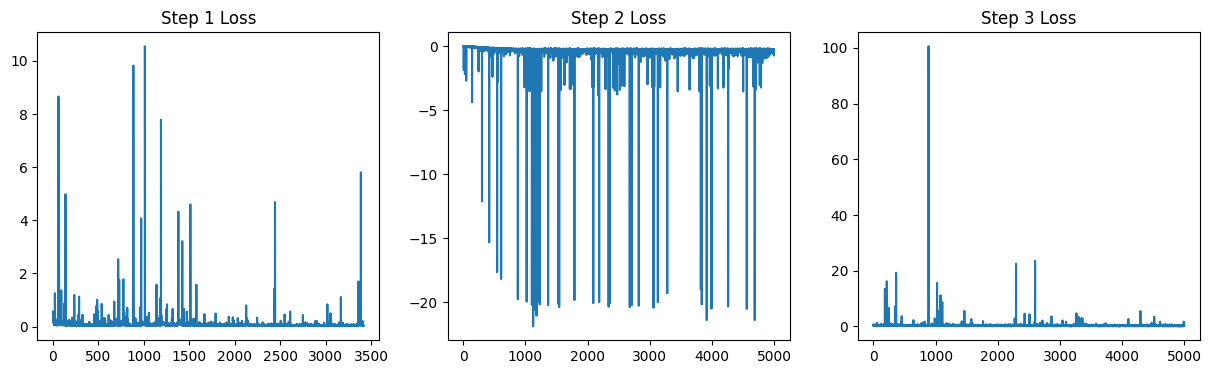


--- TURNOVER ANALYSIS ---
Avg Monthly Turnover: 47.05%
Implied Annual TO:    564.63%
Avg Monthly Cost:     0.0471%

--- NET PERFORMANCE (After 10bps fees) ---
Sharpe (Net):   0.91  (Gross: 0.96)
Return (Net):   11.80%  (Gross: 12.37%)
Max DD (Net):   -13.40%
Sortino Ratio:   2.06
Calmar Ratio:   0.88


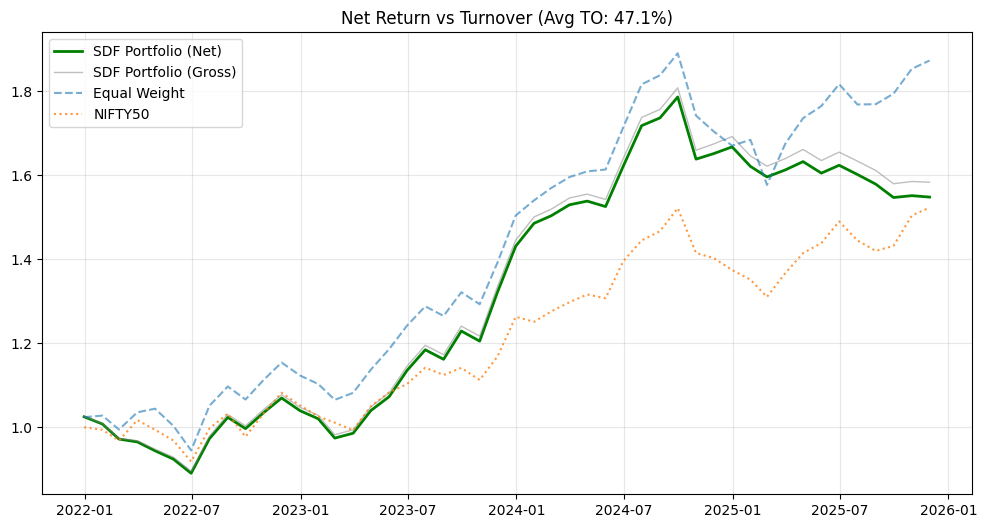

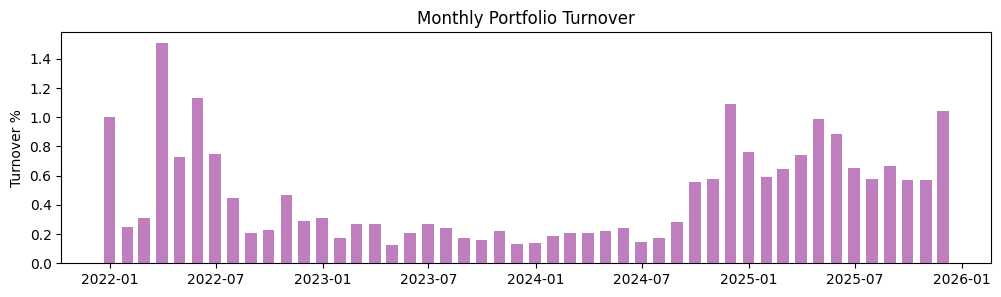

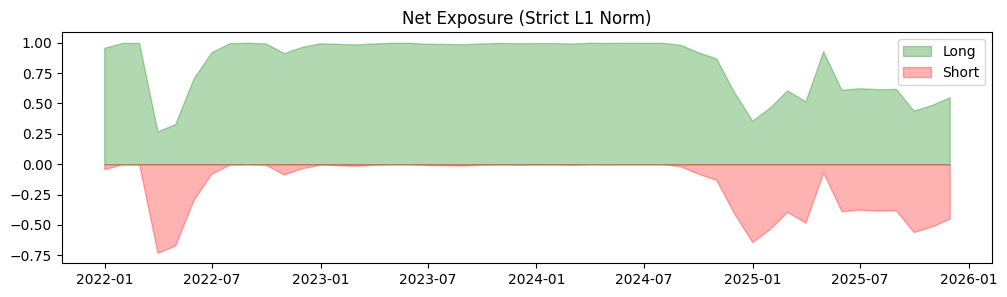


--- LATEST ALLOCATION (Normalized ||w|| = 1) ---
RELIANCE.NS     -0.0215
HDFCBANK.NS     -0.0144
ICICIBANK.NS     0.0085
INFY.NS         -0.0003
TCS.NS          -0.0004
HINDUNILVR.NS   -0.0080
ITC.NS           0.0261
BHARTIARTL.NS    0.0881
KOTAKBANK.NS     0.0462
LT.NS           -0.0117
BAJFINANCE.NS   -0.0184
ASIANPAINT.NS    0.0029
AXISBANK.NS     -0.0114
MARUTI.NS       -0.0108
SUNPHARMA.NS    -0.0244
TITAN.NS        -0.0057
M&M.NS           0.0028
NESTLEIND.NS     0.0650
POWERGRID.NS    -0.0171
ULTRACEMCO.NS   -0.0236
WIPRO.NS        -0.0144
NTPC.NS          0.0122
DRREDDY.NS      -0.0198
BAJAJFINSV.NS   -0.0122
SBIN.NS         -0.0072
TATAMOTORS.NS    0.0401
TECHM.NS         0.0304
HCLTECH.NS       0.0039
DIVISLAB.NS      0.0482
GRASIM.NS        0.0857
TATASTEEL.NS     0.0206
JSWSTEEL.NS     -0.0221
ONGC.NS         -0.0029
BAJAJ-AUTO.NS   -0.0251
INDUSINDBK.NS   -0.0111
CIPLA.NS         0.0104
HEROMOTOCO.NS    0.0026
ADANIPORTS.NS    0.0099
UPL.NS           0.0378
BRITANNIA.NS  

In [22]:
TICKERS = [
    "RELIANCE.NS", "HDFCBANK.NS", "ICICIBANK.NS", "INFY.NS",
    "TCS.NS", "HINDUNILVR.NS", "ITC.NS", "BHARTIARTL.NS", "KOTAKBANK.NS",
    "LT.NS", "BAJFINANCE.NS", "ASIANPAINT.NS", "AXISBANK.NS", "MARUTI.NS",
    "SUNPHARMA.NS", "TITAN.NS", "M&M.NS", "NESTLEIND.NS", "POWERGRID.NS",
    "ULTRACEMCO.NS", "WIPRO.NS", "NTPC.NS", "DRREDDY.NS", "BAJAJFINSV.NS",
    "SBIN.NS", "TATAMOTORS.NS", "TECHM.NS", "HCLTECH.NS", "DIVISLAB.NS",
    "GRASIM.NS", "TATASTEEL.NS", "JSWSTEEL.NS", "ONGC.NS", "BAJAJ-AUTO.NS",
    "INDUSINDBK.NS", "CIPLA.NS", "HEROMOTOCO.NS", "ADANIPORTS.NS", "UPL.NS",
    "BRITANNIA.NS", "TATACONSUM.NS", "ADANIENT.NS", "COALINDIA.NS", "PFC.NS",
    "BPCL.NS", "APOLLOHOSP.NS", "SHREECEM.NS", "SBILIFE.NS", "HDFCLIFE.NS"
] # also had "HDFC.NS"

try:
    print("1. Starting Pipeline...")
    dh = DataHandler(TICKERS)
    m, c, r, mask, d = dh.get_data()
    num_macro_features = m.shape[1]

    # Split
    split = int(len(r) * 0.8)
    train_ds = PortDataset(m[:split], c[:split], r[:split], mask[:split])
    train_ldr = DataLoader(train_ds, batch_size=32, shuffle=True)

    print(f"2. Init Models on {device}...")
    sdf = SDFNetwork(d_m=num_macro_features, d_n=len(TICKERS), d_c=3)
    adv = AdversaryNetwork(d_m=num_macro_features, d_n=len(TICKERS), d_c=3)

    print("3. Training...")
    trainer = GANTrainer(sdf, adv)
    # trainer.train(train_ldr, epochs=[150, 150, 200]) # with specified epoch count
    trainer.train(train_ldr, max_epochs=5000, patience=20)
    trainer.plot()


    bt = VectorBacktester(sdf, m[split:], c[split:], r[split:], mask[split:], d[split:])
    weights = bt.run()

    print("\n--- LATEST ALLOCATION (Normalized ||w|| = 1) ---")
    print(weights.iloc[-1].round(4))
    print(f"Gross Exposure: {weights.iloc[-1].abs().sum():.4f}") # Should be exactly 1.0

except Exception as e:
    import traceback
    traceback.print_exc()